# Catboost pipeline

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

RANDOM_STATE = 42

In [3]:
df = pd.read_csv('../../../full-data/full_processed.csv')

In [4]:
df

,Unnamed: 0.1,Unnamed: 0,price,title,year,mileage,transmission,body_type,drive_type,color,engine_capacity,engine_power,fuel_type,travel_distance,price_scaled,year_scaled,mileage_scaled,engine_capacity_scaled,engine_power_scaled,travel_distance_scaled
0,0,3,189700,Volkswagen Passat B3,1990,325000,механика,универсал 5 дв.,передний,красный,1.8,90.0,Бензин,0,-0.741206,-2.347565,1.312787,-0.569625,-1.059908,-0.00968
1,1,4,370000,Nissan Terrano I,1990,224000,автомат,внедорожник 5 дв.,полный,зелёный,2.7,100.0,Дизель,0,-0.661500,-2.347565,0.409869,0.629041,-0.931058,-0.00968
2,2,5,350000,Honda Civic IV,1990,200000,механика,седан,передний,серебристый,1.6,120.0,Бензин,0,-0.670341,-2.347565,0.195314,-0.835996,-0.673358,-0.00968
3,3,6,360000,Volkswagen Passat B3,1990,200000,механика,универсал 5 дв.,передний,белый,1.8,90.0,Бензин,0,-0.665920,-2.347565,0.195314,-0.569625,-1.059908,-0.00968
4,4,7,99000,Toyota Carina V (T170),1990,296000,автомат,седан,передний,серебристый,1.5,94.0,Бензин,0,-0.781302,-2.347565,1.053533,-0.969181,-1.008368,-0.00968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187689,198874,206342,1600000,Fiat 500e II Рестайлинг,2017,43000,none,хэтчбек 3 дв.,передний,белый,0.0,111.0,Электро,140,NaN,NaN,NaN,NaN,NaN,NaN
187690,198919,206387,600000,Mitsubishi i-MiEV,2012,75000,none,хэтчбек 5 дв.,задний,белый,0.0,67.0,Электро,130,NaN,NaN,NaN,NaN,NaN,NaN
187691,198965,206433,870000,Chevrolet Spark EV III,2013,130000,none,хэтчбек 5 дв.,передний,чёрный,0.0,130.0,Электро,132,NaN,NaN,NaN,NaN,NaN,NaN
187692,198966,206434,870000,Chevrolet Spark EV III,2013,130000,none,хэтчбек 5 дв.,передний,чёрный,0.0,130.0,Электро,132,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
from sklearn.model_selection import train_test_split

X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, shuffle=True)

In [6]:
numerical_cols = ['year', 'mileage', 'engine_capacity', 'engine_power', 'travel_distance']
categorical_cols = ['title', 'transmission', 'body_type', 'drive_type', 'color', 'fuel_type']

In [7]:
current_year = pd.Timestamp.now().year
df['age'] = current_year - df['year']


def clean_mileage(value):
    if pd.isna(value):
        return np.nan

    cleaned = ''.join(filter(str.isdigit, str(value)))
    return float(cleaned) if cleaned else np.nan

df['mileage'] = df['mileage'].apply(clean_mileage)

df['body_style'] = df['body_type'].str.split().str[0]


df['doors'] = df['body_type'].str.extract(r'(\d+)\s?дв').astype(float)


body_door_mapping = {
    'седан': 4,
    'купе': 2,
    'лифтбек': 4,
    'кабриолет': 2,
    'универсал': 5,
    'внедорожник': 5,
    'хэтчбек': 5,
    'минивэн': 5,
    'пикап': 4,
    'фургон': 3
}


for body_style, door_count in body_door_mapping.items():
    mask = df['doors'].isnull() & (df['body_style'] == body_style)
    df.loc[mask, 'doors'] = door_count


df['doors'] = df['doors'].fillna(4)

df = df.drop('body_type', axis=1)



trans_map = {'механика': 0, 'автомат': 1, 'робот': 1, 'вариатор': 1}
df['transmission'] = df['transmission'].map(trans_map).fillna(1)


num_cols = ['mileage', 'engine_capacity', 'engine_power', 'travel_distance', 'age', 'doors']
for col in num_cols:

    df[col].fillna(df[col].median(), inplace=True)


    if col in ['engine_capacity', 'engine_power']:
        df[col] = df[col].replace(0, df[col].median())


cat_cols = ['body_style', 'drive_type', 'color', 'fuel_type']
for col in cat_cols:
    df[col] = df[col].fillna('unknown').astype('category')

df['brand'] = df['title'].str.split().str[0].str.lower().fillna('unknown')

df = df.drop(['title', 'year'], axis=1)

/var/folders/8t/ljy40y7s6_q7mblbcyxxb2ch0000gn/T/ipykernel_15827/921533134.py:52: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/var/folders/8t/ljy40y7s6_q7mblbcyxxb2ch0000gn/T/ipykernel_15827/921533134.py:52: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

In [8]:
X = df.drop('price', axis=1)
y = np.log1p(df['price'])

In [9]:
df

,Unnamed: 0.1,Unnamed: 0,price,mileage,transmission,drive_type,color,engine_capacity,engine_power,fuel_type,...,price_scaled,year_scaled,mileage_scaled,engine_capacity_scaled,engine_power_scaled,travel_distance_scaled,age,body_style,doors,brand
0,0,3,189700,325000.0,0.0,передний,красный,1.8,90.0,Бензин,...,-0.741206,-2.347565,1.312787,-0.569625,-1.059908,-0.00968,35,универсал,5.0,volkswagen
1,1,4,370000,224000.0,1.0,полный,зелёный,2.7,100.0,Дизель,...,-0.661500,-2.347565,0.409869,0.629041,-0.931058,-0.00968,35,внедорожник,5.0,nissan
2,2,5,350000,200000.0,0.0,передний,серебристый,1.6,120.0,Бензин,...,-0.670341,-2.347565,0.195314,-0.835996,-0.673358,-0.00968,35,седан,4.0,honda
3,3,6,360000,200000.0,0.0,передний,белый,1.8,90.0,Бензин,...,-0.665920,-2.347565,0.195314,-0.569625,-1.059908,-0.00968,35,универсал,5.0,volkswagen
4,4,7,99000,296000.0,1.0,передний,серебристый,1.5,94.0,Бензин,...,-0.781302,-2.347565,1.053533,-0.969181,-1.008368,-0.00968,35,седан,4.0,toyota
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187689,198874,206342,1600000,43000.0,1.0,передний,белый,2.0,111.0,Электро,...,NaN,NaN,NaN,NaN,NaN,NaN,8,хэтчбек,3.0,fiat
187690,198919,206387,600000,75000.0,1.0,задний,белый,2.0,67.0,Электро,...,NaN,NaN,NaN,NaN,NaN,NaN,13,хэтчбек,5.0,mitsubishi
187691,198965,206433,870000,130000.0,1.0,передний,чёрный,2.0,130.0,Электро,...,NaN,NaN,NaN,NaN,NaN,NaN,12,хэтчбек,5.0,chevrolet
187692,198966,206434,870000,130000.0,1.0,передний,чёрный,2.0,130.0,Электро,...,NaN,NaN,NaN,NaN,NaN,NaN,12,хэтчбек,5.0,chevrolet


In [10]:
from sklearn.preprocessing import LabelEncoder


for col in ['drive_type', 'color', 'fuel_type', 'body_style', 'brand']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [11]:
!pip install catboost


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [12]:
import catboost

In [13]:
from catboost import CatBoostRegressor

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


model = CatBoostRegressor(
    cat_features=cat_cols + ['brand'],
    iterations=1500,
    learning_rate=0.05,
    depth=7,
    random_seed=42,
    verbose=200
)


In [14]:
model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    early_stopping_rounds=100
)


from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

y_pred = np.expm1(model.predict(X_test))
y_test_exp = np.expm1(y_test)

print(f"R²: {r2_score(y_test_exp, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test_exp, y_pred):.0f} руб.")

0:	learn: 1.0302506	test: 1.0335575	best: 1.0335575 (0)	total: 112ms	remaining: 2m 47s
200:	learn: 0.2883037	test: 0.2927899	best: 0.2927899 (200)	total: 8.77s	remaining: 56.7s
400:	learn: 0.2712194	test: 0.2771571	best: 0.2771571 (400)	total: 17s	remaining: 46.5s
600:	learn: 0.2614434	test: 0.2690336	best: 0.2690336 (600)	total: 25.6s	remaining: 38.3s
800:	learn: 0.2548544	test: 0.2643208	best: 0.2643208 (800)	total: 34.4s	remaining: 30s
1000:	learn: 0.2500247	test: 0.2613036	best: 0.2613036 (1000)	total: 44.1s	remaining: 22s
1200:	learn: 0.2462094	test: 0.2592533	best: 0.2592533 (1200)	total: 53.5s	remaining: 13.3s
1400:	learn: 0.2429456	test: 0.2575921	best: 0.2575907 (1399)	total: 1m 2s	remaining: 4.42s
1499:	learn: 0.2413115	test: 0.2568195	best: 0.2568195 (1499)	total: 1m 7s	remaining: 0us

bestTest = 0.2568195024
bestIteration = 1499

R²: 0.9284
MAE: 284547 руб.


In [15]:
print(f"MSE: {mean_squared_error(y_test_exp, y_pred):.0f} руб.")

MSE: 367103569132 руб.



Оценка точности модели:
R²: 0.9284
MAE: 284547.0000
RMSE: 605890.7238
MAPE: 18.5219%
MAE: 284547 руб.



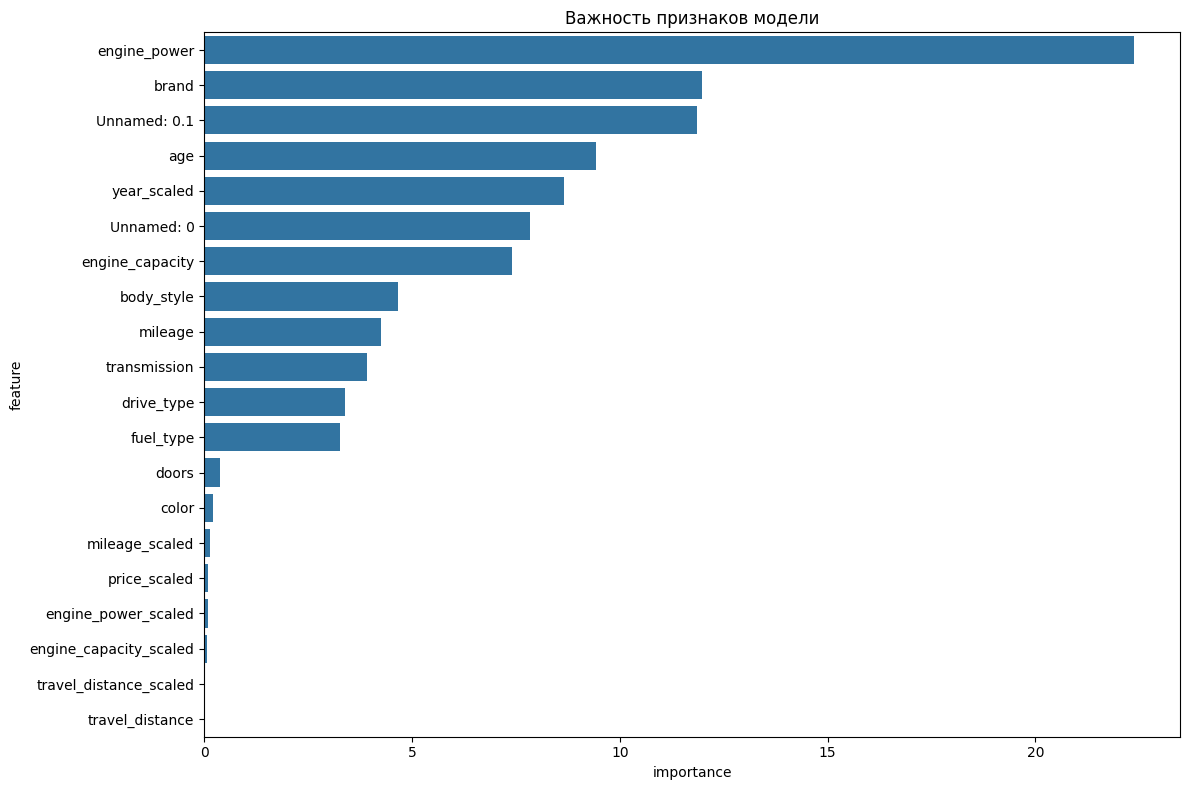

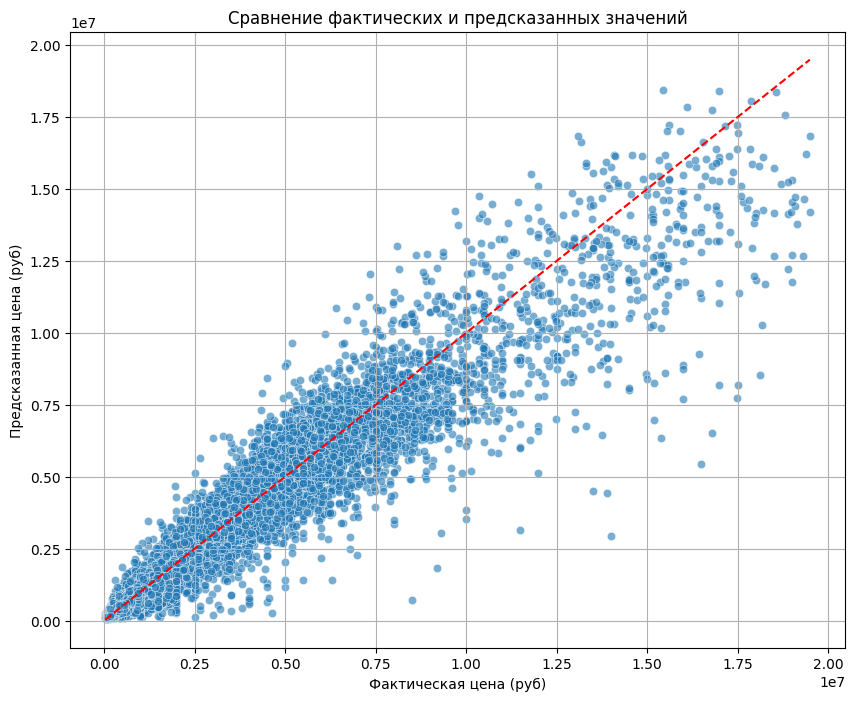

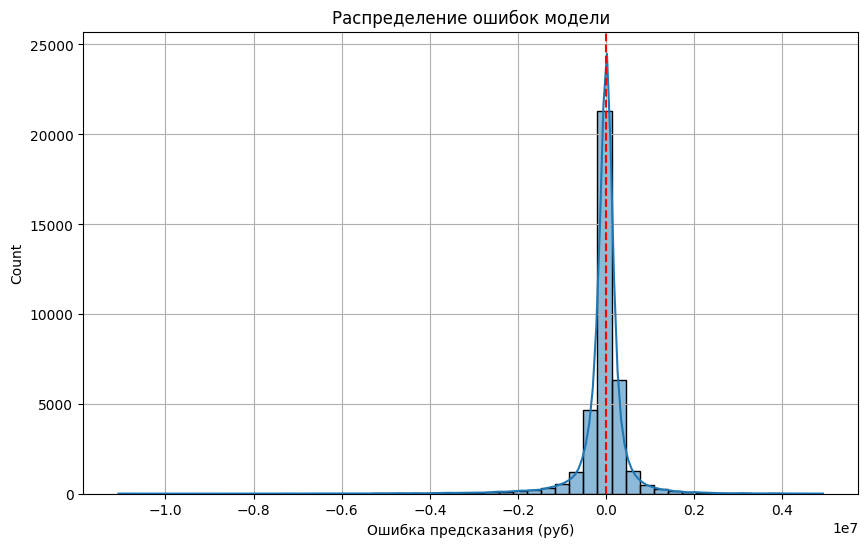


Статистика ошибок по ценовым сегментам:
              mean     median        std
actual                                  
<500к    30.407106  20.891751  34.030812
500к-1м  17.079721  13.178985  15.455023
1-2м     13.585761  10.459327  12.547217
2-5м     13.612038  10.517421  12.345654
>5м      15.786981  13.249691  12.510769


/var/folders/8t/ljy40y7s6_q7mblbcyxxb2ch0000gn/T/ipykernel_15827/4280889692.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_stats = df_results.groupby(price_bins)['error_percent'].agg(['mean', 'median', 'std'])


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


y_pred = np.expm1(model.predict(X_test))
y_test_exp = np.expm1(y_test)

metrics = {
    "R²": r2_score(y_test_exp, y_pred),
    "MAE": mean_absolute_error(y_test_exp, y_pred),
    "RMSE": np.sqrt(mean_squared_error(y_test_exp, y_pred)),
    "MAPE": np.mean(np.abs((y_test_exp - y_pred) / y_test_exp)) * 100
}

print("\n" + "="*50)
print("Оценка точности модели:")
for name, value in metrics.items():
    print(f"{name}: {value:.4f}" + ("%" if name == "MAPE" else ""))
print(f"MAE: {metrics['MAE']:.0f} руб.")
print("="*50 + "\n")


feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.get_feature_importance()
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Важность признаков модели')
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_test_exp, y=y_pred, alpha=0.6)
plt.plot([y_test_exp.min(), y_test_exp.max()],
         [y_test_exp.min(), y_test_exp.max()], 'r--')
plt.xlabel('Фактическая цена (руб)')
plt.ylabel('Предсказанная цена (руб)')
plt.title('Сравнение фактических и предсказанных значений')
plt.grid(True)
plt.show()


errors = y_pred - y_test_exp
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, bins=50)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Ошибка предсказания (руб)')
plt.title('Распределение ошибок модели')
plt.grid(True)
plt.show()


df_results = pd.DataFrame({
    'actual': y_test_exp,
    'predicted': y_pred,
    'error': errors,
    'error_percent': np.abs(errors) / y_test_exp * 100
})


price_bins = pd.cut(df_results['actual'],
                    bins=[0, 500000, 1000000, 2000000, 5000000, float('inf')],
                    labels=['<500к', '500к-1м', '1-2м', '2-5м', '>5м'])

error_stats = df_results.groupby(price_bins)['error_percent'].agg(['mean', 'median', 'std'])
print("\nСтатистика ошибок по ценовым сегментам:")
print(error_stats)

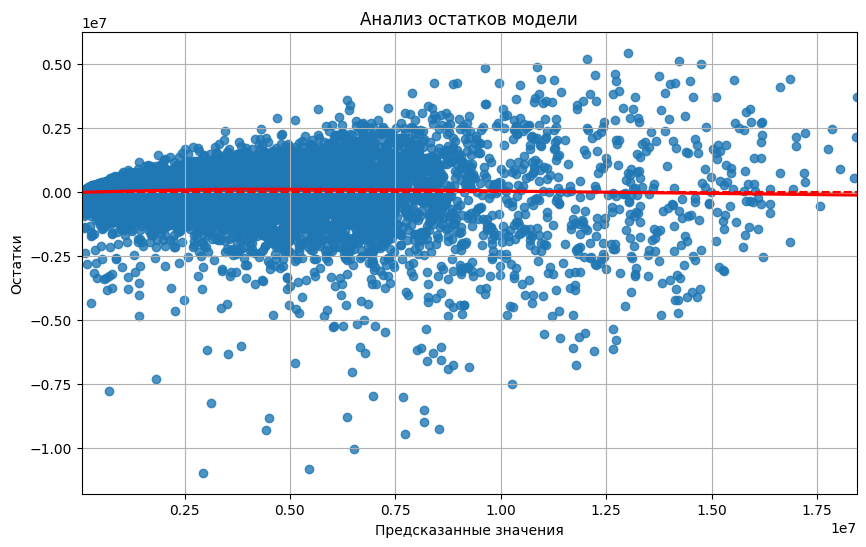


Топ-20 самых больших ошибок:
          actual   predicted  error_percent
20686    50000.0   316726.66         533.45
7577     37000.0   219378.56         492.92
6491     50000.0   263106.77         426.21
22918   300000.0  1417753.30         372.58
15649    67000.0   314370.51         369.21
57166    45000.0   194272.58         331.72
27111    70000.0   302106.10         331.58
80271    70000.0   292033.30         317.19
3782     80000.0   330483.94         313.10
6711    100000.0   402986.98         302.99
17785    50000.0   199651.49         299.30
101840   64999.0   255861.27         293.64
89630    58000.0   227806.85         292.77
5759     40000.0   153863.73         284.66
3929     51500.0   193156.43         275.06
7733    499000.0  1861260.91         273.00
436     101000.0   371738.44         268.06
8551    100000.0   367122.77         267.12
8256     80000.0   288574.85         260.72
24991    50000.0   179576.05         259.15


In [17]:
plt.figure(figsize=(10, 6))
sns.residplot(x=y_pred, y=errors, lowess=True, line_kws={'color': 'red'})
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('Анализ остатков модели')
plt.grid(True)
plt.show()

top_errors = df_results.sort_values('error_percent', ascending=False).head(20)
print("\nТоп-20 самых больших ошибок:")
print(top_errors[['actual', 'predicted', 'error_percent']].round(2))

In [ ]:
if col in ['engine_capacity', 'engine_power']:
    df[col] = df[col].replace(0, df[col].median())

In [ ]:
for col in cat_cols:
    counts = df[col].value_counts()
    mask = df[col].isin(counts[counts < 10].index)
    df.loc[mask, col] = 'other'

/var/folders/8t/ljy40y7s6_q7mblbcyxxb2ch0000gn/T/ipykernel_15827/2278964227.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'other' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[mask, col] = 'other'
/var/folders/8t/ljy40y7s6_q7mblbcyxxb2ch0000gn/T/ipykernel_15827/2278964227.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'other' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[mask, col] = 'other'
/var/folders/8t/ljy40y7s6_q7mblbcyxxb2ch0000gn/T/ipykernel_15827/2278964227.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'other' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[mask, col] = 'ot

In [ ]:
for col in num_cols:
    q1 = df[col].quantile(0.05)
    q3 = df[col].quantile(0.95)
    df[col] = df[col].clip(lower=q1, upper=q3)

In [ ]:
skewed_cols = ['mileage', 'engine_power']
for col in skewed_cols:
    X[col] = np.log1p(X[col])

In [22]:
from catboost import cv
from catboost import Pool


params = {
    'iterations': 1000,
    'learning_rate': 0.05,
    'depth': 6,
    'loss_function': 'RMSE',
    'verbose': False
}

cv_data = cv(
    pool=Pool(X, y, cat_features=cat_cols + ['brand'] + ['drive_type']),
    params=params,
    fold_count=5,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.2657482758
bestIteration = 999

Training on fold [1/5]

bestTest = 0.267605883
bestIteration = 999

Training on fold [2/5]

bestTest = 0.2678995091
bestIteration = 999

Training on fold [3/5]

bestTest = 0.2658855225
bestIteration = 999

Training on fold [4/5]

bestTest = 0.2665870427
bestIteration = 999



In [23]:
cat_cols = ['drive_type', 'color', 'fuel_type', 'brand', 'body_style']


for col in cat_cols:
    df[col] = df[col].astype('category')


model = CatBoostRegressor(
    cat_features=cat_cols,
    iterations=1500,
    learning_rate=0.05,
    depth=7,
    random_seed=42,
    verbose=200
)


model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    early_stopping_rounds=100
)

0:	learn: 1.0302506	test: 1.0335575	best: 1.0335575 (0)	total: 130ms	remaining: 3m 15s
200:	learn: 0.2883037	test: 0.2927899	best: 0.2927899 (200)	total: 11.8s	remaining: 1m 16s
400:	learn: 0.2712194	test: 0.2771571	best: 0.2771571 (400)	total: 23.2s	remaining: 1m 3s
600:	learn: 0.2614434	test: 0.2690336	best: 0.2690336 (600)	total: 39.3s	remaining: 58.8s
800:	learn: 0.2548544	test: 0.2643208	best: 0.2643208 (800)	total: 51.5s	remaining: 45s
1000:	learn: 0.2500247	test: 0.2613036	best: 0.2613036 (1000)	total: 1m 4s	remaining: 32.4s
1200:	learn: 0.2462094	test: 0.2592533	best: 0.2592533 (1200)	total: 1m 16s	remaining: 19.1s
1400:	learn: 0.2429456	test: 0.2575921	best: 0.2575907 (1399)	total: 1m 30s	remaining: 6.43s
1499:	learn: 0.2413115	test: 0.2568195	best: 0.2568195 (1499)	total: 1m 38s	remaining: 0us

bestTest = 0.2568195024
bestIteration = 1499

